# SDK installation

In [1]:
# ! python -m ipykernel install --user \
#         --name clika \
#         --display-name "conda_env"

In [2]:
# check venv
import sys
print(sys.executable)

/home/bar/miniconda3/envs/clika/bin/python


In [3]:
# make sure python version >= 3.8
! python3 --version
! pwd

Python 3.8.16
/home/bar/projects/clika_compression_examples_internal/tutorial_notebooks


In [4]:
# follow installation instruction on
# https://docs.clika.io/docs/installation

# Install dependencies

In [5]:
! pip list | grep clika-compression

clika-compression             0.2.2


In [6]:
! pip3 install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
from typing import Callable, Union, Dict
import argparse
from functools import partial
import warnings
from pathlib import Path

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import torchmetrics

[2023-11-13 21:58:53,819] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# Model source code

### Define base model

In [10]:
class BasicMNIST(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=(2, 2), stride=None, padding=(0, 0), dilation=(1, 1))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [11]:
model = BasicMNIST()

### Define loss function

In [12]:
def compute_loss_fn(pred, target):
    loss = F.nll_loss(
        F.log_softmax(pred, dim=1),
        target
    )

    return loss

### Define optimizer

In [13]:
INITIAL_LR = 0.1

optimizer = torch.optim.Adadelta(params=model.parameters(), lr=INITIAL_LR)

### Define train/eval dataloaders

In [14]:
def get_loader(data_dir, batch_size, num_workers=0, train=True):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = torchvision.datasets.MNIST(root=data_dir,
                                         train=train,
                                         transform=transform,
                                         target_transform=None,
                                         download=True)
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              pin_memory=True,
                                              shuffle=True)
    return data_loader

### Define metric

In [15]:
class MultiClassAccuracy(torchmetrics.classification.accuracy.MulticlassAccuracy):

    def update(self, preds: torch.Tensor, target: torch.Tensor) -> None:
        return super().update(preds, target)

    def compute(self) -> torch.Tensor:
        results = super().compute()
        return results * 100.0

In [16]:
NUM_CLASSES = 10

In [17]:
metric_fn = MultiClassAccuracy(num_classes=NUM_CLASSES)

### Wrap Loss, DataLoaders, Metrics for CLIKA SDK

In [18]:
# Loss
train_losses = {"NLL_loss": compute_loss_fn}
eval_losses = {"NLL_loss": compute_loss_fn}

# DataLoaders
DATA_DIR = "."
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 16
WORKERS = 0
get_train_loader = partial(get_loader, DATA_DIR, TRAIN_BATCH_SIZE, WORKERS, True)
get_eval_loader = partial(get_loader, DATA_DIR, EVAL_BATCH_SIZE, WORKERS, False)

# Metrics
train_metrics = {"acc": metric_fn}
eval_metrics = {"acc": metric_fn}

# Train model with PyTorch

In [19]:
TRAIN_EPOCH = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_criterion = train_losses["NLL_loss"]
eval_criterion = eval_losses["NLL_loss"]
eval_acc = eval_metrics["acc"]
eval_acc.to(device)

for epoch in range(1, TRAIN_EPOCH + 1):
    model.train()
    train_loader = get_train_loader()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = train_criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                  ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    model.eval()
    eval_loader = get_eval_loader()
    loss_list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(eval_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            eval_loss = eval_criterion(output, target)
            loss_list.append(eval_loss.item())

            eval_acc.update(output, target)
    accuracy = eval_acc.compute()
    avg_loss = sum(loss_list) / len(loss_list)
    print(f"\nAccuracy: {accuracy:.3f}, AvgLoss: {avg_loss:.3f}\n")

print("PyTorch training done!!")

Train Epoch: 1 [0/60000                   (0%)]	Loss: 2.335105
Train Epoch: 1 [3200/60000                   (5%)]	Loss: 0.626480
Train Epoch: 1 [6400/60000                   (11%)]	Loss: 0.213223
Train Epoch: 1 [9600/60000                   (16%)]	Loss: 0.482965
Train Epoch: 1 [12800/60000                   (21%)]	Loss: 0.171017
Train Epoch: 1 [16000/60000                   (27%)]	Loss: 0.225028
Train Epoch: 1 [19200/60000                   (32%)]	Loss: 0.124468
Train Epoch: 1 [22400/60000                   (37%)]	Loss: 0.112179
Train Epoch: 1 [25600/60000                   (43%)]	Loss: 0.280294
Train Epoch: 1 [28800/60000                   (48%)]	Loss: 0.063762
Train Epoch: 1 [32000/60000                   (53%)]	Loss: 0.191344
Train Epoch: 1 [35200/60000                   (59%)]	Loss: 0.035457
Train Epoch: 1 [38400/60000                   (64%)]	Loss: 0.431439
Train Epoch: 1 [41600/60000                   (69%)]	Loss: 0.146420
Train Epoch: 1 [44800/60000                   (75%)]	Loss

In [20]:
_trained_ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}
model


BasicMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
_trained_ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}
torch.save(_trained_ckpt, "pytorch_fp32_model.pt")

now our `model` and `optimizer` contain latest checkpoint

# Start QAT from the checkpoint

In [22]:
from clika_compression import PyTorchCompressionEngine, \
    QATQuantizationSettings, \
    DeploymentSettings_TensorRT_ONNX, \
    LayerQuantizationSettings

from clika_compression.settings import (
    generate_default_settings, ModelCompileSettings
)

In [23]:
# Alternatively, you can run QAT from scratch using the flag "is_training_from_scratch" in "PyTorchCompressionEngine.optimize"
# although it will take slgithly longer.

state_dict = torch.load("pytorch_fp32_model.pt", map_location=None)

model.load_state_dict(state_dict["model"])
optimizer.load_state_dict(state_dict["optimizer"])

## 0. Configure QAT settings

In [24]:
settings = generate_default_settings()

In [25]:
# We are applying QAT comprresion method
settings.global_quantization_settings = QATQuantizationSettings()

## 1. Deployment Setting
Let's deploy our model to TensorRT!

TensorRT is a high performance inference engine that can speed up your AI models on Nvidia GPUs.

In [26]:
deployment_setting = DeploymentSettings_TensorRT_ONNX(
    graph_author="CLIKA",
    graph_description=None,
    input_shapes_for_deployment=[(16, 1, 28, 28)]
)

settings.deployment_settings = deployment_setting

## 2. Apply 8 bit quantization on both Weight and Activation tensors.

In [27]:
settings.global_quantization_settings.weights_num_bits = 8
settings.global_quantization_settings.activations_num_bits = 8

## 3. Configure training hyper-parameters

In [28]:
settings.training_settings.num_epochs = 5

# if set limit the number of steps per epoch
settings.training_settings.steps_per_epoch = None
settings.training_settings.evaluation_steps = None
settings.training_settings.lr_warmup_epochs = 0
settings.training_settings.lr_warmup_steps_per_epoch = 0

# number of steps to collect statistics for initial compression
settings.training_settings.stats_steps = 50

# number of steps for averaging losses and accuracies
settings.training_settings.print_num_steps_averaging = 20

# etc
settings.training_settings.print_interval = 50
settings.training_settings.save_interval = 1
settings.training_settings.reset_training_dataset_between_epochs = False
settings.training_settings.reset_evaluation_dataset_between_epochs = False
settings.training_settings.mixed_precision = True
settings.training_settings.use_fp16_weights = False
settings.training_settings.use_gradients_checkpoint = False
settings.training_settings.grads_accumulation_steps = 1

## 4. encapsulate model information
- optimizer
- loss
- metric

In [29]:
mcs = ModelCompileSettings(
    optimizer=optimizer,
    training_losses=train_losses,
    training_metrics=train_metrics,
    evaluation_losses=eval_losses,
    evaluation_metrics=eval_metrics
)

## 5. run compression
- model
- train dataloader
- eval dataloader

In [30]:
OUTPUT_DIR = "./outputs"

In [31]:
engine = PyTorchCompressionEngine()

final = engine.optimize(
    output_path=OUTPUT_DIR,
    settings=settings,
    model=model,
    model_compile_settings=mcs,
    init_training_dataset_fn=get_train_loader,
    init_evaluation_dataset_fn=get_eval_loader,
    is_training_from_scratch=False,
)

Created log at: ./outputs/logs/clika_optimize_2023-11-13_21:59:25.993314.log
[2023-11-13 21:59:25] Initializing output directory at: './outputs/logs'
[2023-11-13 21:59:25] CLIKA Version: 0.2.2
[2023-11-13 21:59:25] 'torch' Version: 2.1.0+cu121
[2023-11-13 21:59:25] Python Version: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
[2023-11-13 21:59:25] Starting Single-GPU optimization
[2023-11-13 21:59:26] 
Training Settings:
	+                              num_epochs = 5
	+                         steps_per_epoch = 1875
	+                        evaluation_steps = -1
	+                             stats_steps = 50
	+   reset_training_dataset_between_epochs = False
	+ reset_evaluation_dataset_between_epochs = False
	+                          print_interval = 50
	+               print_num_steps_averaging = 20
	+                           save_interval = 1
	+                     use_mixed_precision = True
	+                        use_fp16_weights = False
	+                use_gradien

/home/bar/miniconda3/envs/clika/lib/python3.8/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/bar/miniconda3/envs/clika/lib/python3.8/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/bar/miniconda3/envs/clika/lib/python3.8/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/bar/miniconda3/envs/clika/lib/python3.8/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


== License is Valid. Time Left: 266 days 21 hours 34 minutes left ==
[2023-11-13 21:59:28] Saved graph visualization to: outputs/model_init.png
[2023-11-13 21:59:29] Discarding Model
[2023-11-13 21:59:29] Evaluating the Model
[2023-11-13 21:59:29] [ 50/625]	eta: 0:00:00	eval_loss - 0.0003 (0.0296) | eval_NLL_loss - 0.0003 (0.0296)	iter-time: 0.001s	data-time: 0.001s	sys-mem: 20300MiB	vmem: 63MB
[2023-11-13 21:59:29] [100/625]	eta: 0:00:00	eval_loss - 0.0649 (0.0323) | eval_NLL_loss - 0.0649 (0.0323)	iter-time: 0.001s	data-time: 0.001s	sys-mem: 20300MiB	vmem: 63MB
[2023-11-13 21:59:29] [150/625]	eta: 0:00:00	eval_loss - 0.0091 (0.0534) | eval_NLL_loss - 0.0091 (0.0534)	iter-time: 0.001s	data-time: 0.001s	sys-mem: 20300MiB	vmem: 63MB
[2023-11-13 21:59:29] [200/625]	eta: 0:00:00	eval_loss - 0.0015 (0.0374) | eval_NLL_loss - 0.0015 (0.0374)	iter-time: 0.001s	data-time: 0.001s	sys-mem: 20300MiB	vmem: 63MB
[2023-11-13 21:59:29] [250/625]	eta: 0:00:00	eval_loss - 0.0001 (0.0452) | eval_NLL_lo

[2023-11-13 21:59:42] Epoch 1 	[1100/1875]	eta: 0:00:06	loss - 0.2876 (0.0279) | NLL_loss - 0.2876 (0.0279)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20359MiB	vmem: 130MB
[2023-11-13 21:59:42] Epoch 1 	[1150/1875]	eta: 0:00:05	loss - 0.0466 (0.0349) | NLL_loss - 0.0466 (0.0349)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20292MiB	vmem: 130MB
[2023-11-13 21:59:42] Epoch 1 	[1200/1875]	eta: 0:00:05	loss - 0.0929 (0.0404) | NLL_loss - 0.0929 (0.0404)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20303MiB	vmem: 130MB
[2023-11-13 21:59:43] Epoch 1 	[1250/1875]	eta: 0:00:04	loss - 0.0038 (0.0227) | NLL_loss - 0.0038 (0.0227)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20303MiB	vmem: 130MB
[2023-11-13 21:59:43] Epoch 1 	[1300/1875]	eta: 0:00:04	loss - 0.0013 (0.0354) | NLL_loss - 0.0013 (0.0354)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20303MiB	vmem: 130MB
[2023-11-13 21:59:44] Epoch 1 	[1350/1875]	eta: 0:00:04	loss - 0.0005 (0.0689) | NLL_loss - 0.0005 (0.0689)	iter-time: 0.008s	data

[2023-11-13 21:59:53] Epoch 2 	[ 350/1875]	eta: 0:00:12	loss - 0.0011 (0.0189) | NLL_loss - 0.0011 (0.0189)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20438MiB	vmem: 130MB
[2023-11-13 21:59:53] Epoch 2 	[ 400/1875]	eta: 0:00:11	loss - 0.0032 (0.0257) | NLL_loss - 0.0032 (0.0257)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20439MiB	vmem: 130MB
[2023-11-13 21:59:53] Epoch 2 	[ 450/1875]	eta: 0:00:11	loss - 0.0003 (0.0336) | NLL_loss - 0.0003 (0.0336)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20440MiB	vmem: 130MB
[2023-11-13 21:59:54] Epoch 2 	[ 500/1875]	eta: 0:00:10	loss - 0.0278 (0.0277) | NLL_loss - 0.0278 (0.0277)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20440MiB	vmem: 130MB
[2023-11-13 21:59:54] Epoch 2 	[ 550/1875]	eta: 0:00:10	loss - 0.0468 (0.0395) | NLL_loss - 0.0468 (0.0395)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20440MiB	vmem: 130MB
[2023-11-13 21:59:55] Epoch 2 	[ 600/1875]	eta: 0:00:09	loss - 0.0092 (0.0334) | NLL_loss - 0.0092 (0.0334)	iter-time: 0.007s	data

[2023-11-13 22:00:08] Epoch 2 - Evaluating 	[625/625]	eta: 0:00:00	eval_loss - 0.0922 (0.0385) | eval_NLL_loss - 0.0922 (0.0385)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20383MiB	vmem: 130MB
[2023-11-13 22:00:08] Epoch 2 - Evaluating Total time: 0:00:01
[2023-11-13 22:00:08] Summary of Epoch 2
Evaluation
├── eval_NLL_loss = 0.03852
│   ├── Lowest so far = 0.03852 (Epoch: 2)
│   ├── Highest so far = 0.04948 (Epoch: 1)
│   ├── Original value = 0.03053
│   │   └── Difference = ↗ +0.00799,+26.164%
│   └── Previous epoch value = 0.04948 (Epoch 1)
│       └── Difference = ↘ -0.01096,-22.155%
├── eval_acc = 98.88223
│   ├── Lowest so far = 98.7548 (Epoch: 1)
│   ├── Highest so far = 98.88223 (Epoch: 2)
│   ├── Original value = 98.73687
│   │   └── Difference = ↗ +0.14536,+0.147%
│   └── Previous epoch value = 98.7548 (Epoch 1)
│       └── Difference = ↗ +0.12743,+0.129%
└── eval_loss = 0.03852
    ├── Lowest so far = 0.03852 (Epoch: 2)
    ├── Highest so far = 0.04948 (Epoch: 1)
    ├── O

[2023-11-13 22:00:21] Epoch 3 	[1700/1875]	eta: 0:00:01	loss - 0.0067 (0.0182) | NLL_loss - 0.0067 (0.0182)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20348MiB	vmem: 130MB
[2023-11-13 22:00:22] Epoch 3 	[1750/1875]	eta: 0:00:00	loss - 0.0026 (0.0168) | NLL_loss - 0.0026 (0.0168)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20348MiB	vmem: 130MB
[2023-11-13 22:00:22] Epoch 3 	[1800/1875]	eta: 0:00:00	loss - 0.0036 (0.0314) | NLL_loss - 0.0036 (0.0314)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20350MiB	vmem: 130MB
[2023-11-13 22:00:22] Epoch 3 	[1850/1875]	eta: 0:00:00	loss - 0.0122 (0.0163) | NLL_loss - 0.0122 (0.0163)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20347MiB	vmem: 130MB
[2023-11-13 22:00:23] Epoch 3 	[1875/1875]	eta: 0:00:00	loss - 0.0121 (0.0271) | NLL_loss - 0.0121 (0.0271)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20348MiB	vmem: 130MB
[2023-11-13 22:00:23] Epoch 3 Total time: 0:00:14
[2023-11-13 22:00:23] Epoch 3 - Evaluating 	[ 50/625]	eta: 0:00:01	eval_loss - 0

[2023-11-13 22:00:31] Epoch 4 	[ 750/1875]	eta: 0:00:08	loss - 0.0004 (0.0126) | NLL_loss - 0.0004 (0.0126)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20371MiB	vmem: 130MB
[2023-11-13 22:00:31] Epoch 4 	[ 800/1875]	eta: 0:00:08	loss - 0.0008 (0.0087) | NLL_loss - 0.0008 (0.0087)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20371MiB	vmem: 130MB
[2023-11-13 22:00:31] Epoch 4 	[ 850/1875]	eta: 0:00:07	loss - 0.0017 (0.0166) | NLL_loss - 0.0017 (0.0166)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20373MiB	vmem: 130MB
[2023-11-13 22:00:32] Epoch 4 	[ 900/1875]	eta: 0:00:07	loss - 0.1260 (0.0245) | NLL_loss - 0.1260 (0.0245)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20373MiB	vmem: 130MB
[2023-11-13 22:00:32] Epoch 4 	[ 950/1875]	eta: 0:00:07	loss - 0.0010 (0.0126) | NLL_loss - 0.0010 (0.0126)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20373MiB	vmem: 130MB
[2023-11-13 22:00:32] Epoch 4 	[1000/1875]	eta: 0:00:06	loss - 0.0266 (0.0100) | NLL_loss - 0.0266 (0.0100)	iter-time: 0.008s	data

[2023-11-13 22:00:42] Time elapsed: 0:01:09
[2023-11-13 22:00:42] Time left: 0:00:17 (1 epochs left)
[2023-11-13 22:00:43] Saved checkpoint at: './outputs/epoch_4/model.pompom'
[2023-11-13 22:00:43] Starting Epoch 5
[2023-11-13 22:00:43] Epoch 5 	[  50/1875]	eta: 0:00:14	loss - 0.0019 (0.0078) | NLL_loss - 0.0019 (0.0078)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20382MiB	vmem: 130MB
[2023-11-13 22:00:43] Epoch 5 	[ 100/1875]	eta: 0:00:14	loss - 0.0014 (0.0045) | NLL_loss - 0.0014 (0.0045)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20359MiB	vmem: 130MB
[2023-11-13 22:00:44] Epoch 5 	[ 150/1875]	eta: 0:00:13	loss - 0.0000 (0.0139) | NLL_loss - 0.0000 (0.0139)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20360MiB	vmem: 130MB
[2023-11-13 22:00:44] Epoch 5 	[ 200/1875]	eta: 0:00:13	loss - 0.0002 (0.0213) | NLL_loss - 0.0002 (0.0213)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20359MiB	vmem: 130MB
[2023-11-13 22:00:45] Epoch 5 	[ 250/1875]	eta: 0:00:12	loss - 0.0030 (0.0060) | NLL_los

[2023-11-13 22:00:58] Epoch 5 - Evaluating 	[300/625]	eta: 0:00:01	eval_loss - 0.0090 (0.0441) | eval_NLL_loss - 0.0090 (0.0441)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20363MiB	vmem: 130MB
[2023-11-13 22:00:58] Epoch 5 - Evaluating 	[350/625]	eta: 0:00:00	eval_loss - 0.0007 (0.0069) | eval_NLL_loss - 0.0007 (0.0069)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20333MiB	vmem: 130MB
[2023-11-13 22:00:58] Epoch 5 - Evaluating 	[400/625]	eta: 0:00:00	eval_loss - 0.0474 (0.0453) | eval_NLL_loss - 0.0474 (0.0453)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20333MiB	vmem: 130MB
[2023-11-13 22:00:58] Epoch 5 - Evaluating 	[450/625]	eta: 0:00:00	eval_loss - 0.0002 (0.0647) | eval_NLL_loss - 0.0002 (0.0647)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20338MiB	vmem: 130MB
[2023-11-13 22:00:58] Epoch 5 - Evaluating 	[500/625]	eta: 0:00:00	eval_loss - 0.0001 (0.0064) | eval_NLL_loss - 0.0001 (0.0064)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20352MiB	vmem: 130MB
[2023-11-13 22:00:58] Epo

## 6. deploy model
`PyTorchCompressionEngine.deploy(..)` will export your model in [QDQ ONNX format](https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html#onnx-quantization-representation-format)

exported onnx can be compiled on TensorRT SDK for its best performance to NVIDIA GPUs.

see [this page](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#convert-model) for more details about parsing ONNX to TensorRT

In [32]:
final

'outputs/epoch_5/model.pompom'

In [33]:
engine.deploy(
    clika_state_path=final,
    output_dir_path=OUTPUT_DIR,
    file_suffix=None,
    input_shapes=[16,1,28,28],
    graph_author="CLIKA",
    graph_description="Demo - Created by clika.io",
)

[2023-11-13 22:00:59] CLIKA Version: 0.2.2
[2023-11-13 22:00:59] 'torch' Version: 2.1.0+cu121
[2023-11-13 22:00:59] Python Version: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
[2023-11-13 22:00:59] Deploying Model from: outputs/epoch_5/model.pompom
[2023-11-13 22:01:00] Saved model at: ./outputs/BasicMNIST.onnx


'./outputs/BasicMNIST.onnx'

exported "./outputs/BasicMNIST.onnx" visualized


![](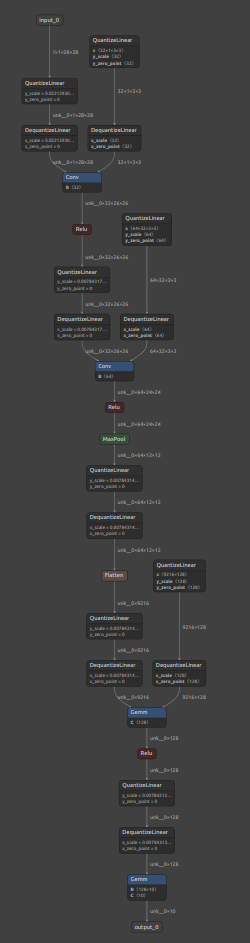
)


Install [tensorrt](https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing) on local machine or use [docker container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tensorrt) to run the following command

In this example we will use docker image for simplicity.

In [34]:
! docker run --gpus all --rm -v .:/workspace/ nvcr.io/nvidia/tensorrt:23.07-py3 -c trtexec \
        --onnx=outputs/BasicMNIST.onnx \
        --int8 --workspace=1024 \
        --saveEngine=outputs/BasicMNIST.engine 


== NVIDIA TensorRT ==

NVIDIA Release 23.07 (build 63868013)
NVIDIA TensorRT Version 8.6.1
Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Container image Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

https://developer.nvidia.com/tensorrt

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

To install Python sample dependencies, run /opt/tensorrt/python/python_setup.sh

To install the open-source samples corresponding to this TensorRT release version
run /opt/tensorrt/install_opensource.sh.  To build the open source parsers,
plugins, and samples for current top-of-tree on master or a different branch,
run /opt/tensorrt/install

[11/13/2023-13:01:07] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in building engine: CPU +1, GPU +4, now: CPU 1, GPU 4 (MiB)
[11/13/2023-13:01:07] [I] Engine built in 5.58039 sec.
[11/13/2023-13:01:07] [I] [TRT] Loaded engine size: 1 MiB
[11/13/2023-13:01:07] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +1, now: CPU 0, GPU 1 (MiB)
[11/13/2023-13:01:07] [I] Engine deserialized in 0.00290898 sec.
[11/13/2023-13:01:07] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +1, now: CPU 0, GPU 2 (MiB)
[11/13/2023-13:01:07] [I] Setting persistentCacheLimit to 0 bytes.
[11/13/2023-13:01:07] [I] Using random values for input input_0
[11/13/2023-13:01:07] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guid

[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0383057 ms - Host latency: 0.0688904 ms (enqueue 0.0161072 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0374939 ms - Host latency: 0.0683105 ms (enqueue 0.0162292 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0361572 ms - Host latency: 0.0693787 ms (enqueue 0.0161621 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0388 ms - Host latency: 0.0702393 ms (enqueue 0.0163818 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0370666 ms - Host latency: 0.0688843 ms (enqueue 0.0163147 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0372803 ms - Host latency: 0.0694458 ms (enqueue 0.016156 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0352234 ms - Host latency: 0.0669006 ms (enqueue 0.0162415 ms)
[11/13/2023-13:01:10] [I] Average on 10 runs - GPU latency: 0.0349182 ms - Host latency: 0.0694519 ms (enqueue 0.0165955 ms)
[11/

## 7. Compare PyTorch, CLIKA deployed performance

In [35]:
# install dependencies to run compiled engine file on python
! pip install tensorrt --extra-index-url https://pypi.ngc.nvidia.com
! git clone https://github.com/NVIDIA-AI-IOT/torch2trt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://pypi.ngc.nvidia.com
fatal: destination path 'torch2trt' already exists and is not an empty directory.


In [36]:
import sys
sys.path.append("torch2trt")

from torch2trt import TRTModule
import tensorrt as trt
trt.__version__

'8.6.1'

In [37]:
# check model input & output names
import onnx

onnx_graph = onnx.load("./outputs/BasicMNIST.onnx").graph
input_names = [n.name for n in onnx_graph.input]
output_names = [n.name for n in onnx_graph.output]
input_names, output_names

(['input_0'], ['output_0'])

In [38]:
ENGINE_PATH = "./outputs/BasicMNIST.engine"

# read trt engine file
with open(ENGINE_PATH, "rb") as fp:
    engine_bytes = fp.read()
with trt.Logger(trt.Logger.INFO) as logger, trt.Runtime(logger) as runtime:
    engine = runtime.deserialize_cuda_engine(engine_bytes)

# initialize trt_model
trt_model = TRTModule(
    engine=engine,
    input_names=input_names,
    output_names=output_names
)

[11/13/2023-22:01:14] [TRT] [I] Loaded engine size: 1 MiB
[11/13/2023-22:01:14] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +1, now: CPU 0, GPU 1 (MiB)
[11/13/2023-22:01:14] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +1, now: CPU 0, GPU 2 (MiB)
[11/13/2023-22:01:14] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


### ORIGINAL fp32 model (PyTorch)

In [39]:

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model.cuda()
model.eval()

# warmup
for _ in range(50):
    _ = model(torch.randn(EVAL_BATCH_SIZE, 1, 28, 28).cuda())

eval_loader = get_eval_loader()
_time_list = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(eval_loader):
        data, target = data.to(device), target.to(device)

        starter.record()
        output = model(data)
        ender.record()
        torch.cuda.synchronize()

        _ff_time = starter.elapsed_time(ender)
        _time_list.append(_ff_time)

        eval_acc.update(output, target)

accuracy = eval_acc.compute()
eval_acc.reset()
avg_time = sum(_time_list) / len(_time_list)
print(EVAL_BATCH_SIZE)
print(f"\nAccuracy: {accuracy:.3f}, latency(sec): {avg_time / 1000}\n")

16

Accuracy: 98.737, latency(sec): 0.00017109155740141867



### CLIKA optimized int8 model (TensorRT)

In [40]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# warmup
for _ in range(50):
    _ = model(torch.randn(EVAL_BATCH_SIZE, 1, 28, 28).cuda())

eval_loader = get_eval_loader()
_time_list = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(eval_loader):
        data, target = data.to(device), target.to(device)

        starter.record()
        output = trt_model(data)
        ender.record()
        torch.cuda.synchronize()

        _ff_time = starter.elapsed_time(ender)
        _time_list.append(_ff_time)

        eval_acc.update(output, target)

accuracy = eval_acc.compute()
eval_acc.reset()
avg_time = sum(_time_list) / len(_time_list)
print(EVAL_BATCH_SIZE)
print(f"\nAccuracy: {accuracy:.3f}, latency(sec): {avg_time / 1000}\n")

16

Accuracy: 99.091, latency(sec): 9.649848428368569e-05



# Resume QAT
Compression process can be resumed from any `.pompom` file.

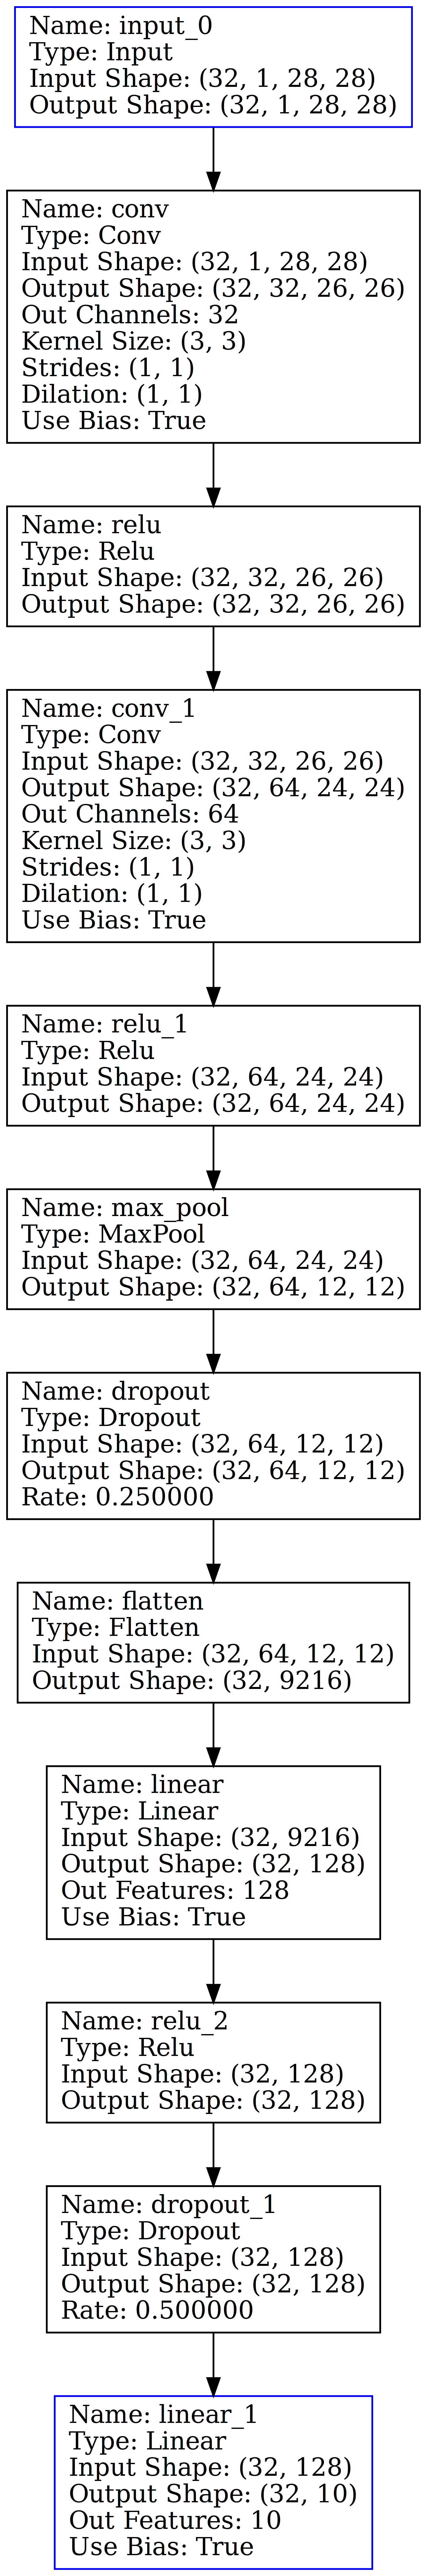

In [41]:
# let's visualize CLIKA SDK extracted model
from IPython.display import Image, display
display(Image(filename="outputs/model_init.png"))

previously we have quantized all layers

let's skip last layer "linear_1" for better accuracy

In [42]:
# skip last layer quantization to maintain higher accuracy
settings.set_quantization_settings_for_layer("linear_1", LayerQuantizationSettings(skip_quantization=True))

In [43]:
engine = PyTorchCompressionEngine()

# skip last layer quantization for better accuracy
last_epoch = settings.training_settings.num_epochs
settings.training_settings.num_epochs = last_epoch + 3  # fine-tune additional 3 epochs

mcs = ModelCompileSettings(
    optimizer=None,
    training_losses=train_losses,
    training_metrics=train_metrics,
    evaluation_losses=eval_losses,
    evaluation_metrics=eval_metrics,
)

In [44]:
final = engine.resume(
    clika_state_path="outputs/epoch_5/model.pompom",
    model_compile_settings=mcs,
    init_training_dataset_fn=get_train_loader,
    init_evaluation_dataset_fn=get_eval_loader,
    settings=settings
)

[2023-11-13 22:01:16] CLIKA Version: 0.2.2
[2023-11-13 22:01:16] 'torch' Version: 2.1.0+cu121
[2023-11-13 22:01:16] Python Version: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
[2023-11-13 22:01:16] Starting Single-GPU optimization
[2023-11-13 22:01:16] Updating to new Settings
[2023-11-13 22:01:16] 
Training Settings:
	+                              num_epochs = 8
	+                         steps_per_epoch = 1875
	+                        evaluation_steps = -1
	+                             stats_steps = 50
	+   reset_training_dataset_between_epochs = False
	+ reset_evaluation_dataset_between_epochs = False
	+                          print_interval = 50
	+               print_num_steps_averaging = 20
	+                           save_interval = 1
	+                     use_mixed_precision = True
	+                        use_fp16_weights = False
	+                use_gradients_checkpoint = False
	+                grads_accumulation_steps = 1
	+                          clip_g

[2023-11-13 22:01:31] Epoch 6 	[1600/1875]	eta: 0:00:02	loss - 0.0120 (0.0260) | NLL_loss - 0.0120 (0.0260)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20695MiB	vmem: 160MB
[2023-11-13 22:01:31] Epoch 6 	[1650/1875]	eta: 0:00:02	loss - 0.0041 (0.0219) | NLL_loss - 0.0041 (0.0219)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20695MiB	vmem: 160MB
[2023-11-13 22:01:32] Epoch 6 	[1700/1875]	eta: 0:00:01	loss - 0.0032 (0.0041) | NLL_loss - 0.0032 (0.0041)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20695MiB	vmem: 160MB
[2023-11-13 22:01:32] Epoch 6 	[1750/1875]	eta: 0:00:01	loss - 0.0006 (0.0132) | NLL_loss - 0.0006 (0.0132)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20699MiB	vmem: 160MB
[2023-11-13 22:01:33] Epoch 6 	[1800/1875]	eta: 0:00:00	loss - 0.0007 (0.0114) | NLL_loss - 0.0007 (0.0114)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20694MiB	vmem: 160MB
[2023-11-13 22:01:33] Epoch 6 	[1850/1875]	eta: 0:00:00	loss - 0.0016 (0.0015) | NLL_loss - 0.0016 (0.0015)	iter-time: 0.008s	data

[2023-11-13 22:01:42] Epoch 7 	[ 850/1875]	eta: 0:00:08	loss - 0.0048 (0.0093) | NLL_loss - 0.0048 (0.0093)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20794MiB	vmem: 160MB
[2023-11-13 22:01:43] Epoch 7 	[ 900/1875]	eta: 0:00:07	loss - 0.0012 (0.0053) | NLL_loss - 0.0012 (0.0053)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20789MiB	vmem: 160MB
[2023-11-13 22:01:43] Epoch 7 	[ 950/1875]	eta: 0:00:07	loss - 0.0001 (0.0046) | NLL_loss - 0.0001 (0.0046)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20788MiB	vmem: 160MB
[2023-11-13 22:01:44] Epoch 7 	[1000/1875]	eta: 0:00:07	loss - 0.0004 (0.0038) | NLL_loss - 0.0004 (0.0038)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20788MiB	vmem: 160MB
[2023-11-13 22:01:44] Epoch 7 	[1050/1875]	eta: 0:00:06	loss - 0.1915 (0.0118) | NLL_loss - 0.1915 (0.0118)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20789MiB	vmem: 160MB
[2023-11-13 22:01:44] Epoch 7 	[1100/1875]	eta: 0:00:06	loss - 0.0001 (0.0266) | NLL_loss - 0.0001 (0.0266)	iter-time: 0.008s	data

[2023-11-13 22:01:53] Time elapsed: 0:00:36
[2023-11-13 22:01:53] Time left: 0:00:18 (1 epochs left)
[2023-11-13 22:01:53] Saved checkpoint at: 'outputs/epoch_5/epoch_7/model.pompom'
[2023-11-13 22:01:53] Starting Epoch 8
[2023-11-13 22:01:53] Epoch 8 	[  50/1875]	eta: 0:00:13	loss - 0.0001 (0.0031) | NLL_loss - 0.0001 (0.0031)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20769MiB	vmem: 160MB
[2023-11-13 22:01:54] Epoch 8 	[ 100/1875]	eta: 0:00:13	loss - 0.0177 (0.0133) | NLL_loss - 0.0177 (0.0133)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20769MiB	vmem: 160MB
[2023-11-13 22:01:56] Epoch 8 	[ 150/1875]	eta: 0:00:32	loss - 0.0001 (0.0026) | NLL_loss - 0.0001 (0.0026)	iter-time: 0.041s	data-time: 0.004s	sys-mem: 20758MiB	vmem: 160MB
[2023-11-13 22:01:56] Epoch 8 	[ 200/1875]	eta: 0:00:26	loss - 0.0034 (0.0044) | NLL_loss - 0.0034 (0.0044)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20758MiB	vmem: 160MB
[2023-11-13 22:01:57] Epoch 8 	[ 250/1875]	eta: 0:00:23	loss - 0.0001 (0.0029) | N

[2023-11-13 22:02:10] Epoch 8 - Evaluating 	[300/625]	eta: 0:00:00	eval_loss - 0.0000 (0.0143) | eval_NLL_loss - 0.0000 (0.0143)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20750MiB	vmem: 160MB
[2023-11-13 22:02:10] Epoch 8 - Evaluating 	[350/625]	eta: 0:00:00	eval_loss - 0.0000 (0.0481) | eval_NLL_loss - 0.0000 (0.0481)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20753MiB	vmem: 160MB
[2023-11-13 22:02:10] Epoch 8 - Evaluating 	[400/625]	eta: 0:00:00	eval_loss - 0.0000 (0.0138) | eval_NLL_loss - 0.0000 (0.0138)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20753MiB	vmem: 160MB
[2023-11-13 22:02:10] Epoch 8 - Evaluating 	[450/625]	eta: 0:00:00	eval_loss - 0.0000 (0.0192) | eval_NLL_loss - 0.0000 (0.0192)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20752MiB	vmem: 160MB
[2023-11-13 22:02:10] Epoch 8 - Evaluating 	[500/625]	eta: 0:00:00	eval_loss - 0.0230 (0.0888) | eval_NLL_loss - 0.0230 (0.0888)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20752MiB	vmem: 160MB
[2023-11-13 22:02:11] Epo